(section:data-loading)=
# Data loading and pre-processing

In [23]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# dimensionality reduction
from sklearn.decomposition import PCA

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

import utils

## Description of the features used
- duration in second: Time taken by the player to complete the path (directly provided in the dataset).
- backtrack: Number of backtracks made by the player in this path.
- numberOfPath: Number of paths previously played by the player, in total.
- position_mean: Character position of succeding clicked link on article page, averaged across all edges of path.
- position_std: Standard deviation of character position of succeding clicked link within a path.
- path_length: Simple measure of number of edges in path (pages clicked on) from beginning to end. Does not contains player backtracks, and so counts the final version of player path.
- coarse_mean_time: Measure of amount of time, on average, that the player took to travel from one edge to another in the path. It is called "coarse" because it is a global measure, that does not take into account outlier edges like the median could. This is especially noticeable on paths where the player disconnected, for example.
- semantic_similarity: This is a measure of the average similarity between two successive terms in the given path. The feature is calculated by computing the cosine similarity (normalised dot product) between embeddings (one-hot vectors projected to a lower dimensionality subspace) given by a sentence transformer, which is a model specifically trained in order to give embeddings which have "semantically relevant" / "semantically informative" relative positions. As such, the cosine similarity gives a measure of logical similarity of the words. A value of -1 represents opposite meanings / topics, around 0 means unrelated, and around 1 means highly similar meanings / topics. The mean of this is supposed to approximately capture how related topics globally were on a given path.
- ratio: The ratio between the user path and the shortest path between the start and end page.
- path_closeness_abs_sum : As each page in the path has a closeness centrality associated to it from the full network of Wikipedia, this features is obtained by looking at the derivative of the closeness centrality of each page in the path (that is, the delta between the closeness centrality of a page and the previous one in the path) and summing the absolute value of these deltas before and after the maximal degree page in the path. 
This is meant to quantify if the player is strongly looking for a hub page in the path, reaches it (as the maximal degree page is assumed to be a hub page) and then goesto a specific page from there, i.e. the target page. Indeed, a good player is expected to have a strongly positive delta before the maximal degree page and a strongly negative delta after it. We take the absolute value then sum them to have a single feature that aims at quantifying this behavior.

In [24]:
DATA_PATH = Path.cwd() / "../data"
FIG_PATH = Path.cwd() / "../src"
FILTER_TIMEOUT = False
if FILTER_TIMEOUT:
    FIG_PATH = FIG_PATH / "figures/leiden/"
else:
    FIG_PATH = FIG_PATH / "figures/leiden_with_timeout/"
FIG_PATH = FIG_PATH.resolve()
print(f"Figure path: {FIG_PATH}")
data = {
    Path(f).stem: pd.read_csv(f, index_col=0) for f in DATA_PATH.glob("combined_*.csv")
}
print(list(data.keys()))
if not FIG_PATH.exists():
    FIG_PATH.mkdir(parents=True)

Figure path: C:\Users\Cyril\Desktop\Code\ada-2023-project-adamants\src\figures\leiden_with_timeout


['combined_metrics_finished_edges', 'combined_metrics_finished_paths', 'combined_metrics_unfinished_edges', 'combined_metrics_unfinished_paths']


In [25]:
features_finished_paths = data["combined_metrics_finished_paths"].reset_index(drop=True)
features_unfinished_paths = data["combined_metrics_unfinished_paths"].reset_index(
    drop=True
)

## Data loading and pre-processing

Let's have a look at features distribution:

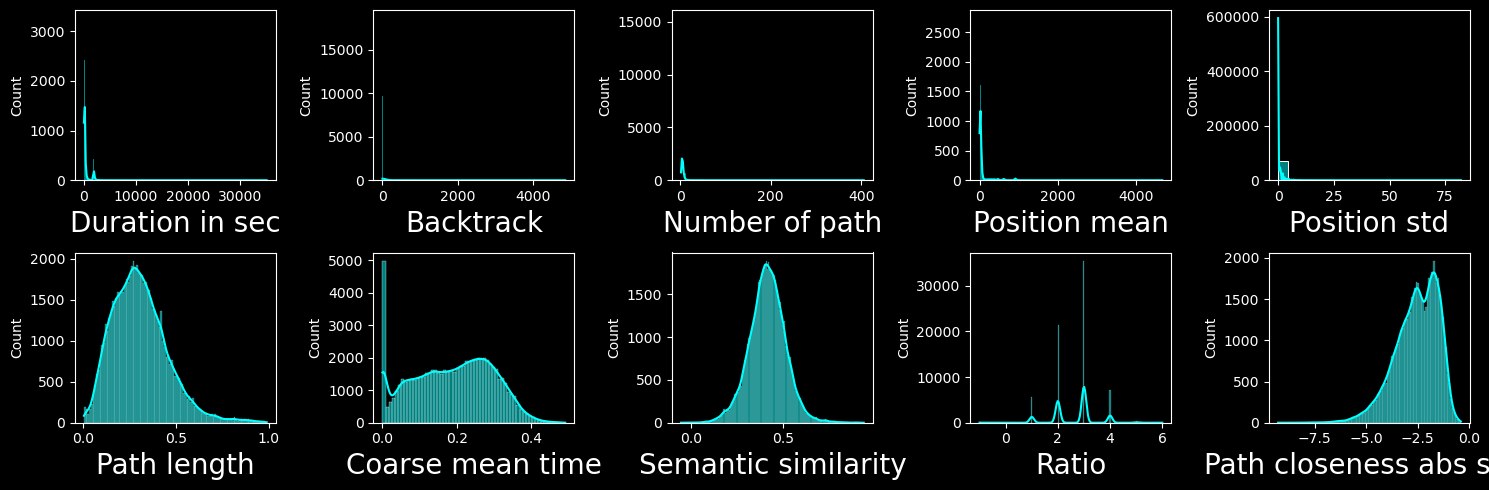

In [37]:
combined_df = pd.concat([features_finished_paths, features_unfinished_paths], axis=0)
with plt.style.context("dark_background"):
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i_log = 0
    i_non_log = len(utils.COLS_LOG)
    for feature in utils.FEATURES_COLS_USED_FOR_CLUSTERING:
        if feature in utils.COLS_LOG:
            i = i_log
            i_log = i_log + 1
        else:
            i = i_non_log
            i_non_log = i_non_log + 1
        ax = axs.flatten()[i]
        sns.histplot(combined_df[feature], kde=True, ax=ax, color="cyan")
        ax.set_xlabel(utils.get_feature_names_labels()[i], fontsize=20)
    fig.tight_layout()
    plt.show()

We can see that the features in the first column are very heavy tailed, for this reason we will apply a log transform to them. 
Taking the log of backtrack (2nd row first column) does not help (probably as it is discrete and has only a few different values).

We will then normalize the features:
- We use z-score normalization
- NaN values in certain features are replaced by the mean

In [38]:
combined_df = pd.concat([features_finished_paths, features_unfinished_paths], axis=0)
combined_df["finished"] = [1] * len(features_finished_paths) + [0] * len(
    features_unfinished_paths
)
combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING] = utils.normalize_features(
    combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING]
)

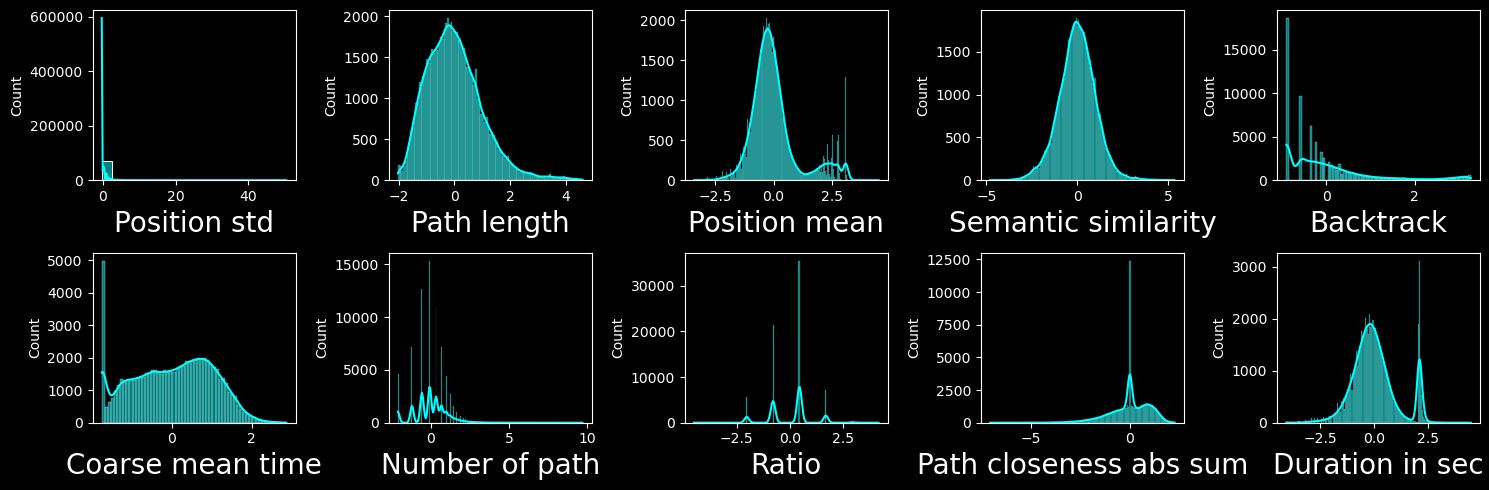

In [39]:
with plt.style.context("dark_background"):
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i_log = 0
    i_non_log = len(utils.COLS_LOG)
    for feature in utils.FEATURES_COLS_USED_FOR_CLUSTERING:
        ax = axs.flatten()[i]
        if feature in utils.COLS_LOG:
            i = i_log
            i_log = i_log + 1
            # set ax to log in x
        else:
            i = i_non_log
            i_non_log = i_non_log + 1
        sns.histplot(combined_df[feature], kde=True, ax=ax, color="cyan")
        ax.set_xlabel(utils.get_feature_names_labels()[i], fontsize=20)
    fig.tight_layout()
    plt.show()

## Correlations and PCA

In [29]:
combined_df.dropna(subset=utils.FEATURES_COLS_USED_FOR_CLUSTERING, inplace=True)
X = combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING].copy().values

### PCA

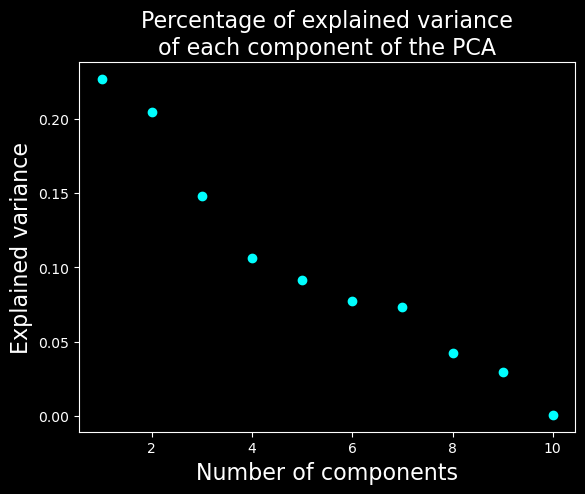

In [30]:
# find the dimensionality of the data
with plt.style.context("dark_background"):
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)
    # plot the explained variance
    plt.scatter(range(1, X.shape[1] + 1), pca.explained_variance_ratio_, c="cyan")
    plt.xlabel("Number of components", fontsize=16)
    plt.ylabel("Explained variance", fontsize=16)
    plt.title("Percentage of explained variance\nof each component of the PCA", fontsize=16)
    plt.show()

We will keep only the 7 first dimensions as they explain most of the variance compared to further components.

### Correlation matrix

In [31]:
# feature names for labels
xlabels = utils.get_feature_names_labels()
ylabels = xlabels.copy()

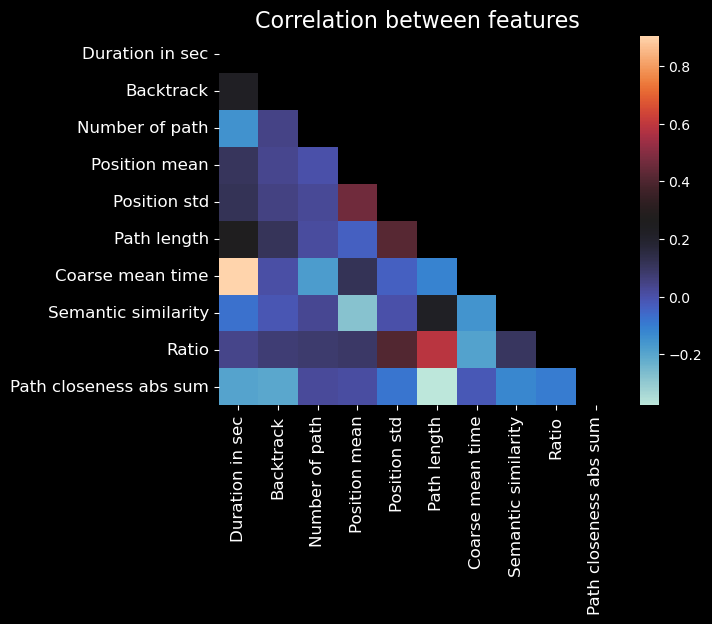

In [32]:
with plt.style.context("dark_background"):
    # show correlation between features
    corr = combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr = corr.mask(mask)
    sns.heatmap(
        corr,
        annot=False,
        cmap="icefire",
        mask=mask,
    )
    plt.title("Correlation between features", fontsize=16)
    xticks_pos = np.arange(len(xlabels)) + 0.5
    plt.xticks(xticks_pos, xlabels, rotation=90, fontsize=12)
    plt.yticks(xticks_pos, ylabels, rotation=0, fontsize=12)
    # TODO fix the tick labels
    plt.show()

```{note}
In the above plot, self-correlations are not shown (as they are always 1). 
```

From this plot, we may notice some noteworthy correlations:
- Time-related features (duration, average_time_on_page, coarse_mean_time) are correlated with each other, which is expected.
- Path length and ratio are correlated with each other, which makes sense as the ratio is the path length divided by the number of pages in the path.